# 0. Import Modules

In [177]:
import numpy as np
import pandas as pd
import scipy.stats as stat

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, auc
import scikitplot as skplt

from datetime import date, timedelta
import math

%matplotlib inline

sns.set_style('whitegrid')
sns.set_palette("Set1", n_colors=8, desat=.5)
# current_palette = sns.color_palette("Set1", n_colors=8, desat=.5)
# sns.palplot(current_palette)

In [2]:
def plot_categorical(df, feature, target):
    sns.factorplot(x = feature, y = target, data = df, aspect = 3)
    
    fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
    
    orders = df[feature].unique().tolist()
    sns.countplot(x = feature, data = df, ax = axis1, order = orders)
    sns.countplot(x = target, hue = feature, data = df, ax = axis2, hue_order = orders)
    sns.barplot(x = feature, y = target, 
                data = df[[feature, target]].groupby(feature).mean().reset_index(),
                order = orders, ax = axis3)
    return

def plot_semi_numeric(df, feature, target, bins1, kde = True):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(df[feature], bins = bins1,kde = kde)
    fig, ax = plt.subplots(figsize=(10,6))
    data = df[[feature, target]].groupby(feature).mean().reset_index()
    plt.scatter(data[feature], data[target])
    plt.plot(data[feature],data[target])
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.show()
    return

def corr_heatmap(data, value_range):
    cmap = mcolors.LinearSegmentedColormap.from_list("n",['#5B7A91', '#AF4F56'])
    vmin = value_range[0]
    vmax = value_range[1]
    vmean = (vmin + vmax) / 2
    corr_matrix = data.corr()
    fig = plt.subplots(1, 1, figsize=(8,8))
    sns.heatmap(corr_matrix, linewidth = 0.5, center = vmean, annot = True, cmap = cmap, vmin = vmin, vmax = vmax)
    return

def plot_distribution(data, feature, target, reference=None):
    if reference == None:
        a = sns.FacetGrid(data, hue = target, aspect = 3)
    else:
        a = sns.FacetGrid(data, hue = target, aspect = 3, row = reference)
    a.map(sns.kdeplot, feature, shade = True)
    a.add_legend()
    return

def get_significance(p_value):
    s = []
    for i in p_value:
        if i <= 0.001:
            s.append('***')
        elif i <= 0.01:
            s.append('**')
        elif i <= 0.05:
            s.append('*')
        else:
            s.append(' ')
    return s

def get_p_value(model, X, y):
    denom = (2.0*(1.0+np.cosh(model.decision_function(X))))
    denom = np.tile(denom,(X.shape[1],1)).T
    F_ij = np.dot((X/denom).T,X) # Fisher Information Matrix
    Cramer_Rao = np.linalg.inv(F_ij) # Inverse Information Matrix
    sigma_estimates = np.array([np.sqrt(Cramer_Rao[i,i]) for i in range(Cramer_Rao.shape[0])]) # sigma for each coefficient
    z_scores = model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
    p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] # two tailed test for p-values
    return z_scores, p_values

# 1. Load Data

In [5]:
df = pd.read_csv('./employee_retention_data.csv')
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [34]:
df.dtypes

employee_id           float64
company_id              int64
dept                   object
seniority               int64
salary                float64
join_date      datetime64[ns]
quit_date      datetime64[ns]
dtype: object

In [33]:
df['join_date'] = pd.to_datetime(df.join_date)
df['quit_date'] = pd.to_datetime(df.quit_date)
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


# Problem 1: Estimate the headcount for each company

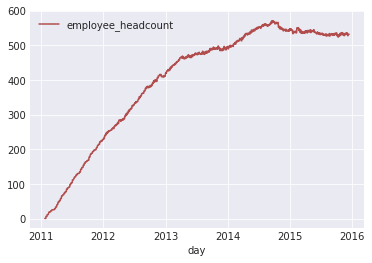

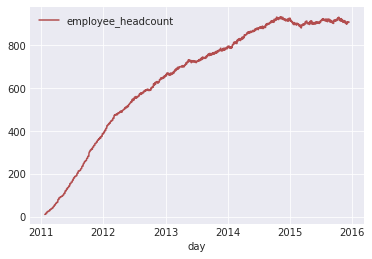

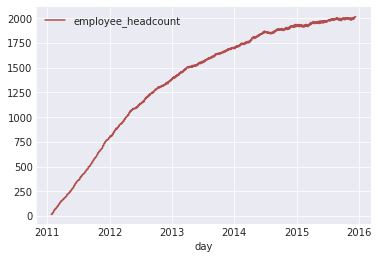

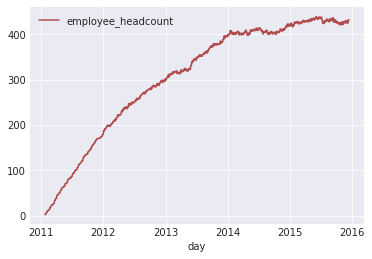

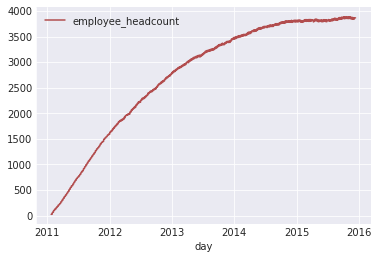

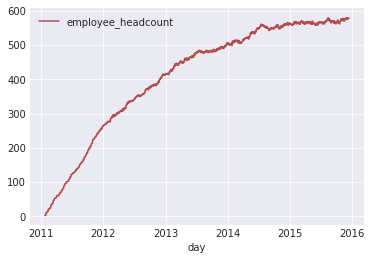

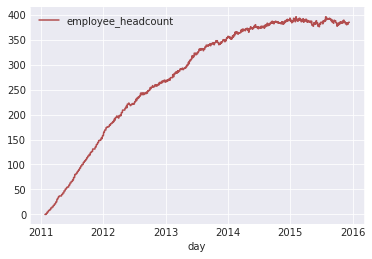

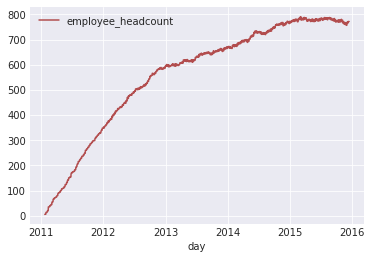

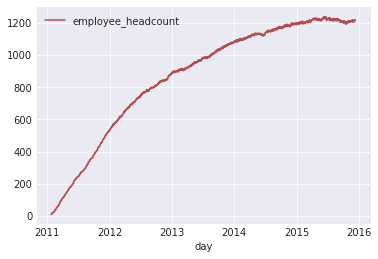

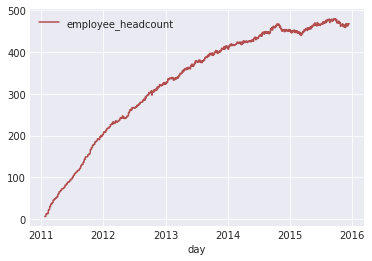

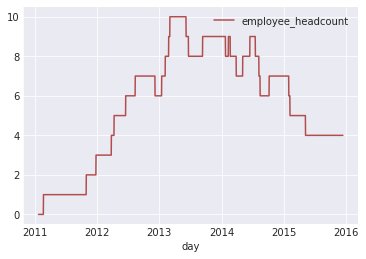

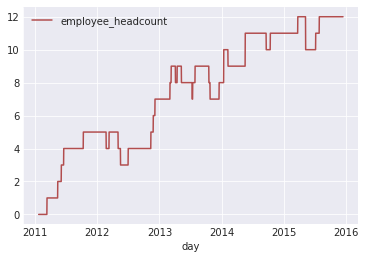

,company_id,day,employee_headcount
0,7,2011-01-24,1
1,7,2011-01-25,1
2,7,2011-01-26,1
3,7,2011-01-27,1
4,7,2011-01-28,1


In [132]:
d1 = date(2011, 1, 24)  # start date
d2 = date(2015, 12, 13)  # end date
# 2011/01/24 to 2015/12/13
delta = d2 - d1         # timedelta

time_range = []
for i in range(delta.days + 1):
    time_range.append(d1 + timedelta(days=i))
tr = pd.Series(time_range)
tr = pd.to_datetime(tr)
tr = list(tr)

sign = False

for com_id in df.company_id.unique():
    company = df[df.company_id == com_id]
    dict1 = {}
    for t in tr:
        dict1[t] = company[(company.join_date <= t) & ((company.quit_date > t) | (company.quit_date.isnull()))]\
                    .employee_id.unique().shape[0]
    new = pd.DataFrame(list(dict1.items()), columns = ['day', 'employee_headcount']).sort_values(by = 'day')\
            .reset_index(drop = True)
    # new['day'] = new.day.dt.date
    fig, ax = plt.subplots(figsize = (6,4))
    sns.set_style("darkgrid")
    new.plot(x='day', y='employee_headcount', ax = ax)
    plt.show()
    new.insert(0, 'company_id', com_id)
    if sign == False:
        result = new.copy()
        sign = True
    else:
        result = pd.concat([result, new], ignore_index = True)
result.head()

# Problem 2: What are the main factors that drive employee churn?

In [134]:
df[df.quit_date.isnull()].shape[0] / df.shape[0]

0.453080722208728

In [185]:
df['length'] = (df.quit_date - df.join_date).dt.days

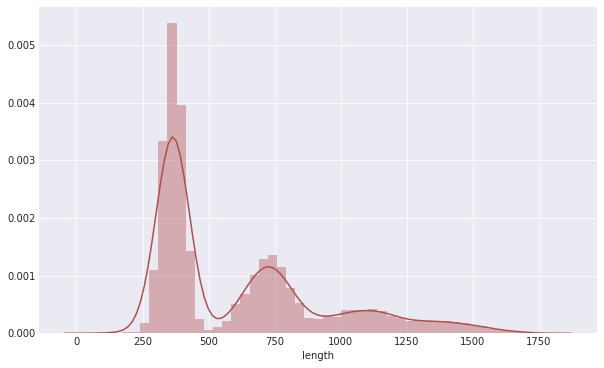

In [191]:
fig, ax = plt.subplots(figsize = (10,6))
sns.distplot(df[df.length.isnull() == False].length, ax = ax)

In [192]:
df['churn'] = df.length.apply(lambda x: 1 - (math.isnan(x) or x > 500)).astype(int)
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,churn,length
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0,585.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,340.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,389.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0,1040.0


In [180]:
df['company_id'] = df.company_id.astype(str)
df.dtypes

employee_id           float64
company_id             object
dept                   object
seniority               int64
salary                float64
join_date      datetime64[ns]
quit_date      datetime64[ns]
churn                   int64
length                float64
dtype: object

In [181]:
X = pd.get_dummies(df.drop(['employee_id','join_date','quit_date','churn','length'], axis = 1), drop_first = True)
y = df.churn

In [182]:
X.head()

,seniority,salary,company_id_10,company_id_11,company_id_12,company_id_2,company_id_3,company_id_4,company_id_5,company_id_6,company_id_7,company_id_8,company_id_9,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
0,28,89000.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,20,183000.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,14,101000.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,20,115000.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,23,276000.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [183]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = 1066)

logreg = LogisticRegression()
logreg.fit(Xtrain, ytrain)

ypred = logreg.predict(Xtest)
# ypred = logreg.predict(Xtest)
print(classification_report(ytest, ypred))

             precision    recall  f1-score   support

          0       0.71      1.00      0.83      3497
          1       0.00      0.00      0.00      1444

avg / total       0.50      0.71      0.59      4941



/home/sguo74/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [184]:
coefficient = pd.DataFrame(list(X.columns))
coefficient.columns = ['Features']
coefficient['Coefficient'] = logreg.coef_[0]

z, p = get_p_value(logreg, Xtrain, ytrain)
p = [round(i,3) for i in p]
# s = get_significance(p)
coefficient['z-score'] = z
coefficient['p-value'] = p
# coefficient['significance'] = s
coefficient

,Features,Coefficient,z-score,p-value
0,seniority,-5.379199e-10,-1.768836e-07,1.0
1,salary,-5.335904e-06,-1.157306e+01,0.0
2,company_id_10,-2.067679e-12,-2.452384e-11,1.0
3,company_id_11,1.179002e-14,2.079058e-14,1.0
4,company_id_12,-1.083337e-13,-2.348813e-13,1.0
5,company_id_2,-8.616930e-12,-1.980649e-10,1.0
6,company_id_3,-6.201924e-12,-1.226241e-10,1.0
7,company_id_4,-3.192186e-12,-5.585844e-11,1.0
8,company_id_5,-3.792251e-12,-6.236806e-11,1.0
9,company_id_6,-2.845525e-12,-4.102592e-11,1.0


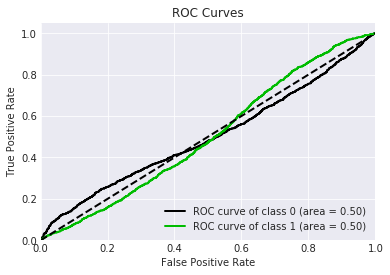

In [193]:
y_true = ytest
y_probas = logreg.predict_proba(Xtest)
skplt.metrics.plot_roc_curve(y_true, y_probas, curves = 'each_class')
plt.show()

In [154]:
df.groupby('churn')['seniority'].median()

churn
0    14
1    14
Name: seniority, dtype: int64

In [195]:
rf = RandomForestClassifier(n_estimators = 500)

rf.fit(Xtrain, ytrain)

# ypred = rf.predict_proba(Xtest)[:,1] > 0.1
# ypred = [int(i) for i in list(rf.predict_proba(Xtest)[:,1] > 0.05)]
ypred = rf.predict(Xtest)
print(classification_report(ytest, ypred))

             precision    recall  f1-score   support

          0       0.71      0.78      0.74      3497
          1       0.31      0.24      0.27      1444

avg / total       0.59      0.62      0.61      4941



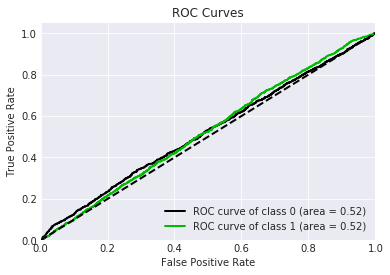

In [196]:
y_true = ytest
y_probas = rf.predict_proba(Xtest)
skplt.metrics.plot_roc_curve(y_true, y_probas, curves = 'each_class')
plt.show()